In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the quasar sample by calculating flux ratios
from class_photoz import ml_quasar_sample as qs
# Load the random forest regression functions
from class_photoz import rf_reg as rf
# Load the random forest classification functions
from class_photoz import rf_class as rf_class
# Load the Machine Learning analysis functions/plots
from class_photoz import ml_analysis as ml_an
# Load the Photometric Redshift analysis functions/plots
from class_photoz import photoz_analysis as pz_an


# 1) Random Forest Photometric Redshift Estimation
## a) Load the training set and prepare the features

In [9]:
# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5','data')

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

df_train.replace(np.inf, np.nan,inplace=True)
df_train.query('10 > Z_VI > 0.0 and SDSS_mag_i < 21.5',inplace=True)

df_train, features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

# Possibility of running on a subsample for testing
# df_train = df_train.sample(frac=0.5)



## b) Run the Random Forest Regression Example

Feature Importances 
SDSS_i: 0.0183608743171
WISE_w1: 0.0729868321413
ug: 0.323622020223
gr: 0.0717373529595
ri: 0.0559330875163
iz: 0.0431592345052
zw1: 0.375187943342
w1w2: 0.0390126549953


Explained Variance Score
[ 0.81350802]


Mean Absolute Error
[ 0.18300785]


Mean Squared Error
[ 0.13852898]
Standard deviation: 
0.372177664117
R 0.3 :  0.857807940723
R 0.2 :  0.767253532671
R 0.1 :  0.534146421429
Redshift normalized standard devation: 
0.164653602129
Photometric Redshift evaluation
Total number of test objects :  30501
Delta z < 0.3 :  0.954558866922
Delta z < 0.2 :  0.925149995082
Delta z < 0.1 :  0.835218517426


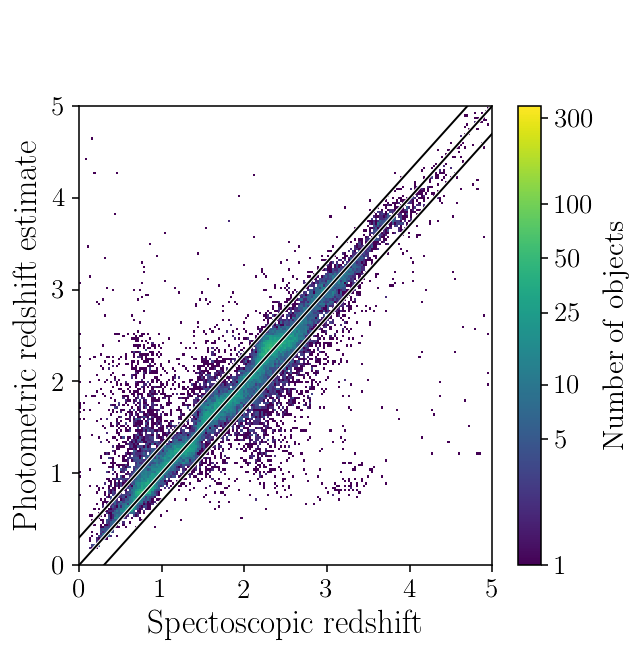

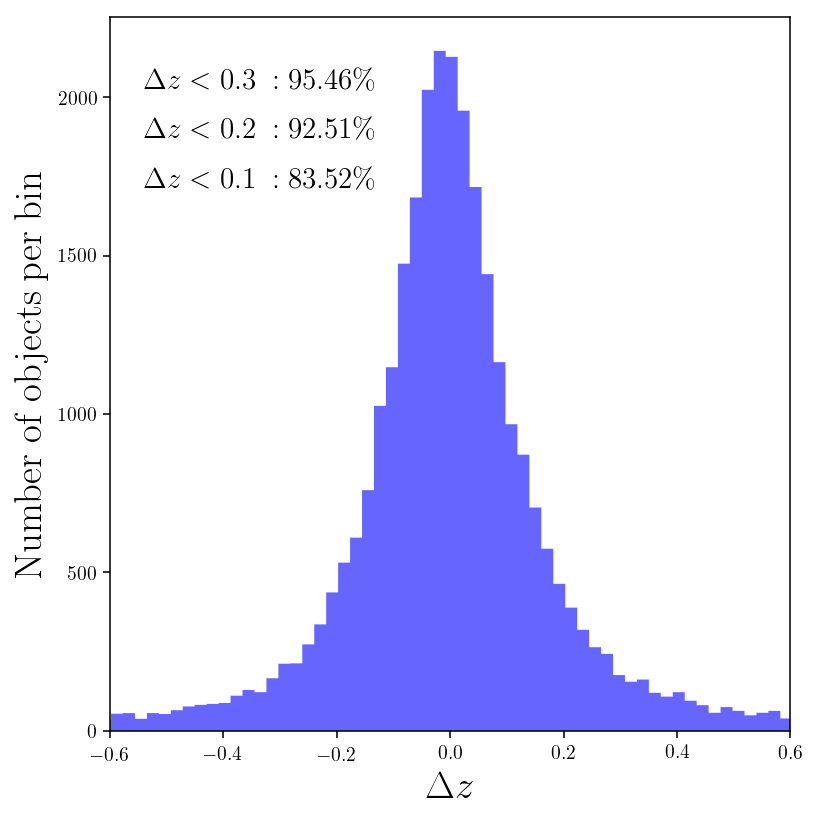

In [10]:
# --------------------------------------------------------------------------
# Random Forest Regression Grid Search
# --------------------------------------------------------------------------

features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
# features = ['SDSS_i','WISE_w1','TMASS_j','ug','gr','ri','iz','zj','jh', 'hk', 'kw1', 'w1w2']
label = 'z'
rand_state = 1

params = {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 2, 'n_jobs': 2, 'random_state':rand_state,}


rf.rf_reg_example(df_train,features,label,params,rand_state,save=True,save_filename='test')

# 2) Random Forest Classification 
## a) Load the training sets, prepare the features and the label

In [11]:
df_stars = pd.read_hdf('../class_photoz/data/DR13_stars_clean_flux_cat_minimal.hdf5', 'data')
df_quasars = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5', 'data')

passband_names = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', \
                    # 'TMASS_j', \
                    # 'TMASS_h', \
                    # 'TMASS_k', \
                    'WISE_w1', \
                    'WISE_w2', \
                    # 'WISE_w3', \
                    # 'WISE_w4', \
                    ]

df_stars, features = \
    qs.prepare_flux_ratio_catalog(df_stars, passband_names)
df_quasars, features = \
    qs.prepare_flux_ratio_catalog(df_quasars, passband_names)


df_stars.query('SDSS_mag_i <= 21.5', inplace=True)
df_quasars.query('SDSS_mag_i <= 21.5', inplace=True)

print "Stars: ", df_stars.shape
print "Quasars: ", df_quasars.shape

# Create detailed classes
df_quasars = qs.create_qso_labels(df_quasars, 'mult_class_true', 'z')
df_stars = qs.create_star_labels(df_stars, 'mult_class_true', 'star_class')

# Create binary classes
df_quasars['bin_class_true'] = 'QSO'
df_stars['bin_class_true'] = 'STAR'


Stars:  (245070, 43)
Quasars:  (152503, 45)
Quasar classes with new labels: 

vlowz    56879
midz     53882
lowz     37248
highz     4397
Name: mult_class_true, dtype: int64
Stellar classes with new labels: 

F    99654
M    59557
K    47904
G    18487
A    16017
Name: mult_class_true, dtype: int64


## b) Run the Random Forest classification 

Classification Report 
             precision    recall  f1-score   support

          A       0.86      0.67      0.75      3178
          F       0.82      0.92      0.86     19872
          G       0.63      0.31      0.41      3618
          K       0.91      0.89      0.90      9636
          M       0.98      0.99      0.98     12020
      highz       0.91      0.85      0.88       875
       lowz       0.85      0.82      0.84      7385
       midz       0.88      0.93      0.90     10751
      vlowz       0.92      0.92      0.92     11471

avg / total       0.87      0.88      0.87     78806



Feature Importance 
SDSS_i: 0.0532090886747
WISE_w1: 0.0496634279834
ug: 0.171776968282
gr: 0.171710466157
ri: 0.183695199435
iz: 0.0916743787464
zw1: 0.186341603416
w1w2: 0.0919288673056




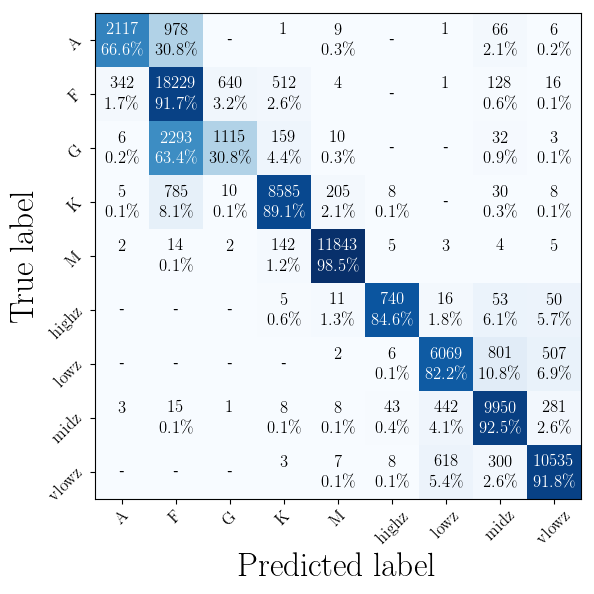

In [12]:
# Make test and training set
df_train, df_pred = qs.make_train_pred_set(df_stars, df_quasars, 0.2, rand_state = 1)


features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']

label = 'mult_class_true'

params = {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 3,
          'n_jobs': 2, 'random_state': 1}

rand_state = 1

y_true, y_pred, df_prob = rf_class.rf_class_example(df_train, df_pred,
                          features, label, params, rand_state)

# 3) Validation Curve

Some Information from scikit-learn:

It is sometimes helpful to plot the influence of a single hyperparameter on the training score and the
validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible.

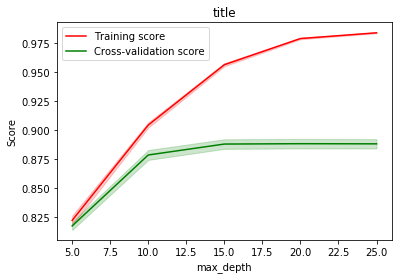

In [3]:
from class_photoz import ml_sets as sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5','data')

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

df_train.replace(np.inf, np.nan,inplace=True)
df_train.query('10 > Z_VI > 0.0 and SDSS_mag_i < 21.5',inplace=True)

df_train, features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

label = 'Z_VI'
features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
rand_state = 1

# Building test and training sample
X,y = sets.build_matrices(df_train, features, label)

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=rand_state)

# Random Forest Regression
params = {'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'n_jobs': 2, 'random_state':rand_state}

reg = RandomForestRegressor(**params)


param_name = 'max_depth'
param_range = [5,10,15,20,25]

ml_an.plot_validation_curve(reg, param_name, param_range, 'title', X, y, cv=3, ylim=None, n_jobs=2)

plt.show()

# 4) Learning Curve

Some information from scikit-learn:

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

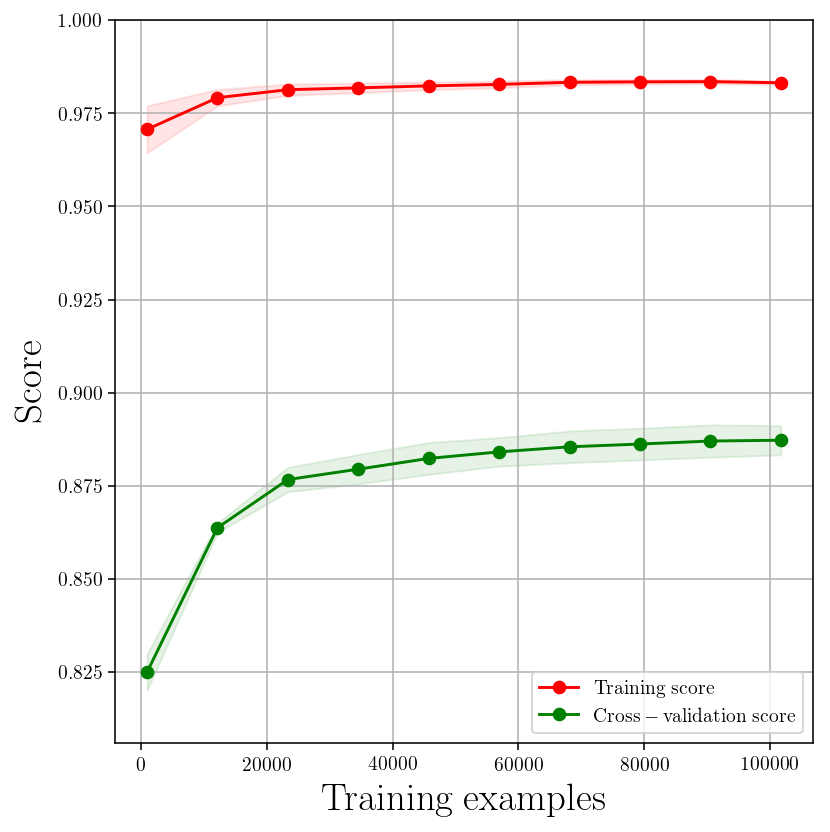

In [4]:
from class_photoz import ml_sets as sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5','data')

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

df_train.replace(np.inf, np.nan,inplace=True)
df_train.query('10 > Z_VI > 0.0 and SDSS_mag_i < 21.5',inplace=True)

df_train, features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

label = 'Z_VI'
features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
rand_state = 1

# Building test and training sample
X,y = sets.build_matrices(df_train, features, label)

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=rand_state)

# Random Forest Regression
params = {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 2, 'n_jobs': 2, 'random_state':rand_state}

reg = RandomForestRegressor(**params)

ml_an.plot_learning_curve(reg, X, y, ylim=None, cv=3, n_jobs=2, train_sizes=np.linspace(.01, 1.0, 10))

plt.show()

# 5) Hyperparameter grid search

In [8]:
# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5','data')

df_train = df_train.sample(frac=0.1)

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

df_train.replace(np.inf, np.nan,inplace=True)

df_train,features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

# --------------------------------------------------------------------------
# Random Forest Regression Grid Search
# --------------------------------------------------------------------------

features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
label = 'Z_VI'
rand_state = 1
param_grid = [{'n_estimators': [10, 50, 100], 'min_samples_split': [2, 3], \
                 'max_depth' : [10, 15]} ]

scores = ['r2']



rf.rf_reg_grid_search(df_train,features,label,param_grid,rand_state,scores,'example')


Training sample size:  (12483, 8)
Evaluation sample size:  (3121, 8)
# Tuning hyper-parameters for r2
()
Best parameters set found on training set:
()
{'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 15}
()
Grid scores on training set:
()
0.852 (+/-0.014) for {'min_samples_split': 2, 'n_estimators': 10, 'max_depth': 10}
0.860 (+/-0.017) for {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 10}
0.861 (+/-0.017) for {'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 10}
0.853 (+/-0.012) for {'min_samples_split': 3, 'n_estimators': 10, 'max_depth': 10}
0.861 (+/-0.017) for {'min_samples_split': 3, 'n_estimators': 50, 'max_depth': 10}
0.862 (+/-0.017) for {'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 10}
0.852 (+/-0.014) for {'min_samples_split': 2, 'n_estimators': 10, 'max_depth': 15}
0.862 (+/-0.018) for {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 15}
0.864 (+/-0.017) for {'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 15}
0

# 7) Receiver Operating Characteristic 

Some information from scikit-learn:

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

Stars:  (245070, 43)
Quasars:  (152503, 45)
Quasar classes with new labels: 

vlowz    56879
midz     53882
lowz     37248
highz     4397
Name: mult_class_true, dtype: int64
Stellar classes with new labels: 

F    99654
M    59557
K    47904
G    18487
A    16017
Name: mult_class_true, dtype: int64


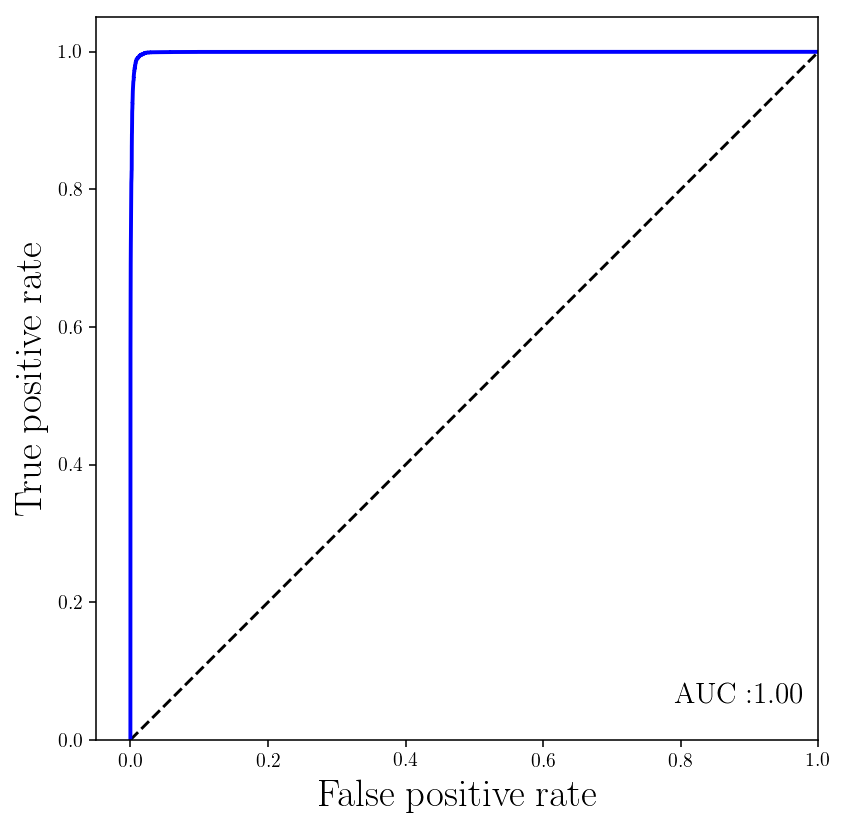

In [7]:
from class_photoz import ml_sets as sets

df_stars = pd.read_hdf('../class_photoz/data/DR13_stars_clean_flux_cat_minimal.hdf5', 'data')
df_quasars = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5', 'data')

passband_names = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', \
                    # 'TMASS_j', \
                    # 'TMASS_h', \
                    # 'TMASS_k', \
                    'WISE_w1', \
                    'WISE_w2', \
                    # 'WISE_w3', \
                    # 'WISE_w4', \
                    ]

df_stars, features = \
    qs.prepare_flux_ratio_catalog(df_stars, passband_names)
df_quasars, features = \
    qs.prepare_flux_ratio_catalog(df_quasars, passband_names)


df_stars.query('SDSS_mag_i <= 21.5', inplace=True)
df_quasars.query('SDSS_mag_i <= 21.5', inplace=True)

print "Stars: ", df_stars.shape
print "Quasars: ", df_quasars.shape

# Create detailed classes
df_quasars = qs.create_qso_labels(df_quasars, 'mult_class_true', 'z')
df_stars = qs.create_star_labels(df_stars, 'mult_class_true', 'star_class')

# Create binary classes
df_quasars['bin_class_true'] = 'QSO'
df_stars['bin_class_true'] = 'STAR'

df_train, df_pred = qs.make_train_pred_set(df_stars, df_quasars, 0.2, rand_state = 1)


features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']

label = 'bin_class_true'

params = {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 10,
          'n_jobs': 2, 'random_state': 1}

rand_state = 1

clf, y_pred, y_prob = rf_class.rf_class_predict(df_train,df_pred, features, label,
                                                            params, rand_state)

X_pred, y_true = sets.build_matrices(df_pred, features,label=label)

ml_an.plot_roc_curve(y_true, y_prob[:,0], pos_label='QSO')

plt.show()